# Method 1: RoBERTa-lstm

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from torch.utils.data import Dataset

class upload_dataset(Dataset):
    def __init__(self, data_file):
        self.data = self.load_data(data_file)
    
    def load_data(self, data_file):
        Data = {}
        with open(data_file, 'rt', encoding='utf-8') as f:
            for idx, line in enumerate(f):
                items = line.strip().split('\t')
                assert len(items) == 2
                Data[idx] = {
                    'comment': items[0], 
                    'label': int(items[1]),
                }
        return Data
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

C:\Users\JASONZ7\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# testing 
train_data = upload_dataset('chnsenticorp/train/part.0')
valid_data = upload_dataset('chnsenticorp/dev/part.0')
test_data = upload_dataset('chnsenticorp/test/part.0')
print(f'train set size: {len(train_data)}')
print(f'valid set size: {len(valid_data)}')
print(f'test set size: {len(test_data)}')
print(next(iter(train_data)))

train set size: 9600
valid set size: 1200
test set size: 1200
{'comment': '选择珠江花园的原因就是方便，有电动扶梯直接到达海边，周围餐馆、食廊、商场、超市、摊位一应俱全。酒店装修一般，但还算整洁。 泳池在大堂的屋顶，因此很小，不过女儿倒是喜欢。 包的早餐是西式的，还算丰富。 服务吗，一般', 'label': 1}


In [3]:
def map_label(tokenizer):
    return {
        '1': {'token': '好', 'id': tokenizer.convert_tokens_to_ids("好")},
        '0': {'token': '差', 'id': tokenizer.convert_tokens_to_ids("差")}
    }

In [4]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
checkpoint = 'hfl/chinese-roberta-wwm-ext'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# find the id of the label defined in tokenizer
label = map_label(tokenizer)
pos_id, neg_id = label['1']['id'], label['0']['id']
# Dataloader, in NLP we usually use collate_fn to do the padding to make sure samples have the same sequence length
def collate(batch_samples): # operate on each batch
    batch_sentence = []
    batch_label = []
    batch_mask_id = []
    max_length = 0
    for sample in batch_samples:
        batch_sentence.append(sample['comment'])
        encoding = tokenizer(sample['comment'], truncation=True)
        max_length = max(max_length, len(encoding.tokens())) # dynamic padding to the longest 
        batch_label.append(sample['label']) 
    batch_inputs = tokenizer(batch_sentence, max_length=512, padding=True, truncation=True, return_tensors="pt") 
    label_id = [neg_id, pos_id]
    return {
        'batch_inputs':batch_inputs,
        'label_id': label_id,
        'labels': batch_label
        
    }

# Build the model

In [5]:
from transformers import BertModel
checkpoint = 'hfl/chinese-roberta-wwm-ext'
pre_trained_model = BertModel.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
vocab_size = len(tokenizer)
print(vocab_size)
print(pre_trained_model)

21128
BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(21128, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
    

In [6]:
for param in pre_trained_model.parameters():
    param.requires_grad_(False)

In [7]:
class bert_lstm(torch.nn.Module):
    def __init__(self, pre_trained_model, hidden_dim, class_size, num_layer, drop_prob):
        super().__init__()
        self.fc = torch.nn.Linear(hidden_dim, class_size)
        self.md = pre_trained_model
        self.lstm = torch.nn.LSTM(768, hidden_dim, num_layer, batch_first=True)
        self.dropout = torch.nn.Dropout(drop_prob)
    def forward(self, batch_inputs, label_id, labels):
        
        input_data = batch_inputs
        with torch.no_grad():
            out = self.md(**input_data)
        output = out.last_hidden_state
        lstm_out, (hidden_last, cn_last) = self.lstm(output) # we only care about hidden_last[-1]
        out = self.dropout(hidden_last[-1])
        out = self.fc(out)
        return out

# Data preperation

In [8]:
from transformers import AdamW
from tqdm import tqdm
# Hyper-parameters
hidden_dim = 384 # output hidden dim of lstm
class_size = 2
num_layer = 2
drop_prob = 0.2


model = bert_lstm(pre_trained_model, hidden_dim, class_size, num_layer, drop_prob)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=4e-5)
loss_fun = torch.nn.CrossEntropyLoss()
num_epoch = 10
batch_size = 32

# put dataset to GPU
def to_device(batch_data):
    new_batch_data = {}
    for k, v in batch_data.items():
        if k == 'batch_inputs':
            new_batch_data[k] = {
                k_: v_.to(device) for k_, v_ in v.items()
            }
        elif k == 'label_id':
            new_batch_data[k] = v
        else:
            new_batch_data[k] = torch.tensor(v).to(device)
    return new_batch_data

# encapsulate into the dataloader as input
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate)  # common bug: dimension not match as this model supports maximum 512 tokens
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, collate_fn=collate)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, collate_fn=collate)

# logs
loss_hists = {'train':[],'val': []}
acc_hists = {'train':[],'val': []}

c:\Users\JASONZ7\.conda\envs\pytorch\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10: 100%|██████████| 300/300 [03:03<00:00,  1.63it/s]


Epoch 1/10, Training Loss: 0.4604, Training accuracy: 0.7963
Epoch 1/10, Validation loss: 0.3639, Validation accuracy: 0.8298


Epoch 2/10: 100%|██████████| 300/300 [03:45<00:00,  1.33it/s]


Epoch 2/10, Training Loss: 0.3189, Training accuracy: 0.8745
Epoch 2/10, Validation loss: 0.3275, Validation accuracy: 0.8495


Epoch 3/10: 100%|██████████| 300/300 [03:46<00:00,  1.32it/s]


Epoch 3/10, Training Loss: 0.2952, Training accuracy: 0.8799
Epoch 3/10, Validation loss: 0.3026, Validation accuracy: 0.8643


Epoch 4/10: 100%|██████████| 300/300 [03:57<00:00,  1.26it/s]


Epoch 4/10, Training Loss: 0.2790, Training accuracy: 0.8886
Epoch 4/10, Validation loss: 0.3028, Validation accuracy: 0.8709


Epoch 5/10: 100%|██████████| 300/300 [03:44<00:00,  1.33it/s]


Epoch 5/10, Training Loss: 0.2610, Training accuracy: 0.8976
Epoch 5/10, Validation loss: 0.2984, Validation accuracy: 0.8742


Epoch 6/10: 100%|██████████| 300/300 [03:57<00:00,  1.26it/s]


Epoch 6/10, Training Loss: 0.2488, Training accuracy: 0.9046
Epoch 6/10, Validation loss: 0.2866, Validation accuracy: 0.8717


Epoch 7/10: 100%|██████████| 300/300 [04:04<00:00,  1.23it/s]


Epoch 7/10, Training Loss: 0.2303, Training accuracy: 0.9120
Epoch 7/10, Validation loss: 0.2968, Validation accuracy: 0.8668


Epoch 8/10: 100%|██████████| 300/300 [04:14<00:00,  1.18it/s]


Epoch 8/10, Training Loss: 0.2236, Training accuracy: 0.9157
Epoch 8/10, Validation loss: 0.3083, Validation accuracy: 0.8750


Epoch 9/10: 100%|██████████| 300/300 [04:11<00:00,  1.20it/s]


Epoch 9/10, Training Loss: 0.2343, Training accuracy: 0.9111
Epoch 9/10, Validation loss: 0.2892, Validation accuracy: 0.8832


Epoch 10/10: 100%|██████████| 300/300 [04:02<00:00,  1.24it/s]


Epoch 10/10, Training Loss: 0.2471, Training accuracy: 0.9010
Epoch 10/10, Validation loss: 0.2931, Validation accuracy: 0.8824


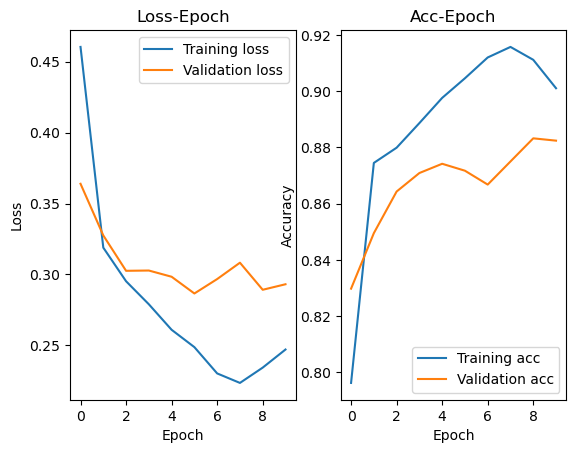

In [9]:
import matplotlib.pyplot as plt
for epoch in range(num_epoch):
    train_loss = 0
    i = 1
    correct_num = 0
    num_batch = 0
    for batch_data in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epoch}"):
      if num_batch < 600:
        model.train() # training mode
        batch_data = to_device(batch_data)
        output = model(**batch_data)
        loss = loss_fun(output, batch_data['labels'])
        loss.backward()
        train_loss+=loss.item()

        optimizer.step()
        optimizer.zero_grad()# set gradient to 0 when batch is updated


        # if i % 10 == 0: # record every 10 training batches
        #     output = output.argmax(dim=1)
        #     acc = (output == batch_data['labels']).sum().item()/ len(batch_data['labels'])
        #     print(f'Training stage:Batch {i}, Loss: {loss.item()}, Accuracy: {acc}')

        # if i % 30 == 0: # validate every 30 batches
        #     model.eval()
        #     batch_val = next(iter(valid_loader))
        #     with torch.no_grad():
        #         batch_val = to_device(batch_val)
        #         output = model(**batch_val)
        #     val_loss = loss_fun(output, torch.tensor(batch_val['labels']))
        #     output = output.argmax(dim=1)
        #     acc = (output == torch.tensor(batch_val['labels'])).sum().item()/ len(batch_val['labels'])
        #     print(f'Validation stage:Batch {i}, Loss: {loss.item()}, Accuracy: {acc}')

        # i+=1
        num_batch+=1
        output = output.argmax(dim=1)
        correct_num += (output == batch_data['labels']).sum().item()
      else:
        break

    acc = correct_num/(num_batch*batch_size)
    average_loss = train_loss/num_batch
    loss_hists['train'].append(average_loss)
    acc_hists['train'].append(acc)
    print(f"Epoch {epoch + 1}/{num_epoch}, Training Loss: {average_loss:.4f}, Training accuracy: {acc:.4f}")

    # validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        correct_num = 0
        for i, batch_data in enumerate(valid_loader):
            batch_data = to_device(batch_data)
            output = model(**batch_data)
            loss = loss_fun(output, batch_data['labels'])
            output = output.argmax(dim=1)

            correct_num += (output == batch_data['labels']).sum().item()
            val_loss+=loss

        acc = correct_num/ (len(valid_loader)*batch_size)
        average_val_loss = val_loss/len(valid_loader)

        loss_hists['val'].append(average_val_loss)
        acc_hists['val'].append(acc)
        print(f'Epoch {epoch + 1}/{num_epoch}, Validation loss: {average_val_loss:.4f}, Validation accuracy: {acc:.4f}')


# draw the loss figures
fig, ax = plt.subplots(1,2)
ax[0].plot(torch.tensor(loss_hists['train']).cpu().detach().numpy()) # can only matplotlib to plot numpy on CPU
ax[0].plot(torch.tensor(loss_hists['val']).cpu().detach().numpy())
ax[0].set_title('Loss-Epoch')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(['Training loss', 'Validation loss'])

ax[1].plot(torch.tensor(acc_hists['train']).cpu().detach().numpy())
ax[1].plot(torch.tensor(acc_hists['val']).cpu().detach().numpy())
ax[1].set_title('Acc-Epoch')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend(['Training acc', 'Validation acc'])
plt.show()